In [105]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from astropy.io import fits
from scipy import ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import sample
from astropy.visualization import ZScaleInterval, ImageNormalize
import random
import torch.backends.cudnn as cudnn
from datetime import datetime

In [79]:
batch_size=1
dataset_name="hi_data"
root = '../data/training/'
dim=(64, 64, 64)
train_size = 0.6
nEpochs=10
classes=2
inChannels=1
shuffle = True
terminal_show_freq=50
model='VNET'
num_workers=2
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 5
model_name = model
date_str = ""
subsample = 1
scale = ""
save = ('../saved_models/fold_' + str(k) + '_checkpoints/' + model_name + '_', dataset_name + "_" + date_str)[0]

In [29]:
# MAKE REPRODUCIBLE
torch.manual_seed(42)
np.random.seed(42)
cudnn.deterministic = True
# FOR FASTER GPU TRAINING WHEN INPUT SIZE DOESN'T VARY
# LET'S TEST IT
cudnn.benchmark = True

In [80]:
# input and target files
model_name = model

inputs = [root+scale+'Input/' + x for x in listdir(root+scale+'Input') if ".fits" in x]
targets = [root+'Target/mask_' + x.split("/")[-1].split("_")[-1] for x in inputs]
dataset_full = SegmentationDataSet(inputs=inputs,
                                    targets=targets,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root=root)
cubes = [i.split("/")[-1] for i in inputs]
cubes = sample(cubes, subsample)
k = 5
train_list, val_list, test_list = [], [], []
for cube in cubes:
    file_list = [i for i in dataset_full.list if cube in i[0][0]]
    random.shuffle(file_list)
    file_list = file_list[:10]
    for i in range(len(file_list)):
        file_list[i][0][0] = "."+file_list[i][0][0]
        file_list[i][0][1] = "."+file_list[i][0][1]
    num_test_val = int(len(file_list)*(1 - train_size)/2)
    num_train =int(len(file_list)*train_size)
    train_list +=(file_list[:num_train])
    val_list +=(file_list[num_train:num_train+num_test_val])
    test_list +=(file_list[num_train+num_test_val:num_train+2*num_test_val])
# dataset training
dataset_train = SegmentationDataSet(inputs=inputs,
                                    targets=targets,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root=root,
                                    list=train_list)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs,
                                    targets=targets,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root=root,
                                    list=val_list)

# dataset validation
dataset_test = SegmentationDataSet(inputs=inputs,
                                    targets=targets,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root=root,
                                    list=test_list)
now = datetime.now() # current date and time
date_str = now.strftime("%d%m%Y_%H%M%S")
save = ('./saved_models/fold_' + str(k) + '_checkpoints/' + model_name + '_', dataset_name + "_" + date_str)[0]
# dataloader training
params = {'batch_size': batch_size,
        'shuffle': shuffle,
        'num_workers': num_workers}
dataloader_training = DataLoader(dataset=dataset_train, **params)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, **params)
# dataloader test
dataloader_test = DataLoader(dataset=dataset_test, **params)

In [62]:
# print('--------------------------------')
# print('FOLD %s'%k)
# print('--------------------------------')
# class argsclass:
#     def __init__(self, model, opt, lr, inChannels, classes):
#         self.model = model
# #         self.opt=opt
#         self.lr=lr
#         self.inChannels=1
#         self.classes=2
#         self.cuda = False
#         self.dataset_name = 'hi_source'
#         self.log_dir = "./runs/"
#         self.terminal_show_freq = 15
#         self.nEpochs = 2
#         self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
# args = argsclass(model_name, opt, lr, inChannels, classes)

# model, optimizer = create_model(args)
# criterion = DiceLoss(classes=args.classes)
# save = ('../saved_models/fold_' + str(k) + '_checkpoints/' + model_name + '_', dataset_name + "_" + date_str)[0]
# save += "test"
# args.save = save
# trainer = Trainer(args, model, criterion, optimizer, train_data_loader=dataloader_training,
#                         valid_data_loader=dataloader_validation, lr_scheduler=None)
# print("START TRAINING...")
# trainer.training()

In [82]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 2, "../saved_models/fold_4_checkpoints/VNET_/VNET__BEST.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45603934


1

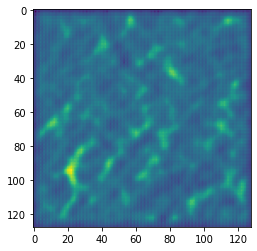

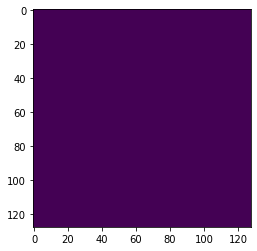

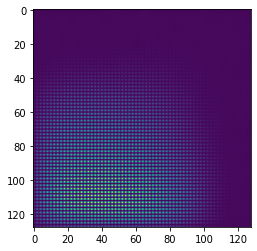

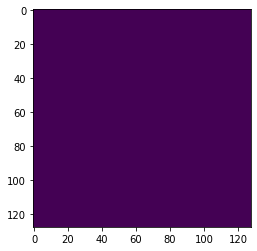

In [88]:
# Evaluationfor this fold
dice_losses, total = 0, 1
model.eval()
with torch.no_grad():
    for batch_idx, input_tuple in enumerate(dataloader_test):
        input_tensor, target = input_tuple
        out_cube = model.inference(input_tensor)# Grab in numpy array
        out_np = out_cube.squeeze()[0].numpy()
        target_np = target.squeeze().numpy()
        plt.imshow(out_np[..., 34])
        plt.show()
        plt.imshow(target_np[..., 34])
        plt.show()

In [146]:
def prepare_data(data):
    interval = ZScaleInterval()
    return interval(np.nan_to_num(np.moveaxis(data, 0, 2)))

orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")[133:197, 800:800+128, 1500:1500+128]
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")[133:197, 800:800+128, 1500:1500+128]
prepared_data = prepare_data(orig_data)
mask_tensor = torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)# Grab in numpy array
    out_np = out_cube.squeeze()[0].numpy()
target_np = np.moveaxis(realseg_data, 0, 2)

In [181]:
np.nanmean(smoothed_gal), np.nanstd(smoothed_gal), np.max(smoothed_gal)

(-0.4296634, 0.03663804, 0.060074337)

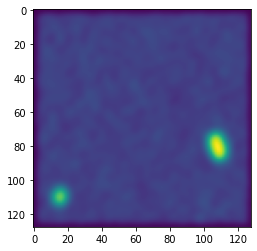

0.44818136522172397


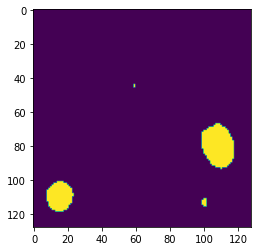

In [191]:
# Turn probabilities to mask
smoothed_gal = ndi.gaussian_filter(out_np, sigma=2)
# Relabel each object seperately
plt.imshow(smoothed_gal[..., 34])
plt.show()
t = np.nanmean(smoothed_gal) + np.nanstd(smoothed_gal)
new_mask = (smoothed_gal > t)
intersection = np.nansum(np.logical_and(target_np, new_mask).astype(int))
plt.imshow(new_mask[..., 34])
if np.nansum(target_np) == np.nansum(new_mask) == 0:
    dice = 1
else:
    union = np.nansum(target_np) + np.nansum(new_mask)
    dice = (2*intersection)/(union)
print(dice)

# # Print accuracy
# print('Average dice loss for fold ', k , ":", (100.0*dice_losses/total), "%")
# print('--------------------------------')
# results[k] = 100.0 * (dice_losses / total)
# # Print fold results
# print('K-FOLD CROSS VALIDATION RESULTS FOR %s FOLDS'%k_folds)
# print('--------------------------------')
# sum = 0.0
# for key, value in results.items():
# print('Fold ', key, ":", value, " %")
# sum += value
# av = sum/len(results.items())
# print('Average: ', av, "%")

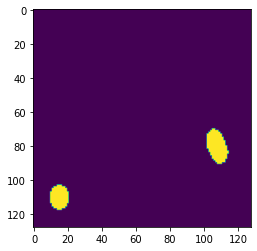

In [111]:
plt.imshow(target_np[..., 34])